In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import mpl_toolkits.mplot3d

from scipy.optimize import fsolve
import scipy.sparse.linalg as spla

import numpy as np
import numpy.linalg as la

import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from torus_points import *

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [458]:
def torus_forcing(nodes):
#     a, b = np.sqrt(4), np.sqrt(20)
    a, b = 2, 2*3
    
    # create gaussian centers
    theta_cs = np.array([0, .5,   1,    2, 4, 5, 3.141])
    phi_cs   = np.array([0,  4, 1.5, -1.5, 0, 4, 3.141/2])
#     theta_cs = [0]
#     phi_cs = [np.pi]
#     shapes = [1, .5, 2, 1, .7, .9, 1]
    shapes = [1]*len(phi_cs)
    
    thetas, phis = get_parameters(nodes, 1, 1/3)
    
    N, K = len(nodes), len(theta_cs)
    
    us = np.zeros(N)
    lap = np.zeros(N)
    
    ct, st = np.cos(thetas), np.sin(thetas)
    cp, sp = np.cos(phis), np.sin(phis)
    for k in range(K):
        s = shapes[k]
        spk = np.sin(phis - phi_cs[k])
        cpk = np.cos(phis - phi_cs[k])
        stk = np.sin(thetas - theta_cs[k])
        ctk = np.cos(thetas - theta_cs[k])
        
        uk = np.exp(-s* (a**2*(1-cpk) + b**2*(1-ctk))  )
#         C = 1*a**4*s**2*spk**2*cp*ct + 3*a**4*s**2*spk**2*cp + \
#             3*a**4*s**2*spk**2*ct + 9*a**4*s**2*spk**2 - 1*a**2*s*cp*ct*cpk \
#             - 3*a**2*s*cp*cpk - 3*a**2*s*ct*cpk - 9*a**2*s*cpk \
#             + b**4*s**2*stk**2 - b**2*s*ctk
        C = 1*a**4*s**2*spk**2*cp**2 + 6*a**4*s**2*spk**2*cp + 9*a**4*s**2*spk**2 \
                + 1*a**2*s*sp*spk*cp + 3*a**2*s*sp*spk - 1*a**2*s*cp**2*cpk - 6*a**2*s*cp*cpk \
                - 9*a**2*s*cpk + b**4*s**2*stk**2 - b**2*s*ctk
        C /= (1+cp/3)**2
        lap += C*uk
        us += uk
    return us, lap

<IPython.core.display.Javascript object>


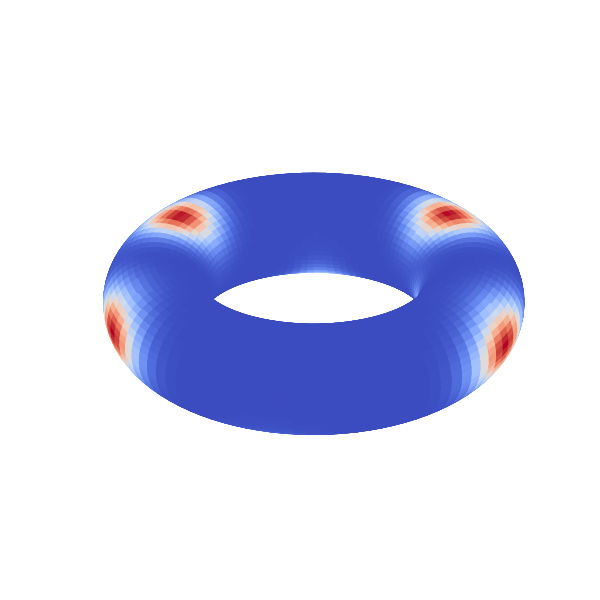

In [443]:
n_t, n_p = 100, 50

thetas = np.linspace(0, 2*np.pi, n_t)
phis = np.linspace(0, 2*np.pi, n_p)

U = np.outer(np.ones(n_p), thetas).flatten()
V = np.outer(phis, np.ones(n_t)).flatten()

nodes = torus_to_cart(U, V, 1, 1/3)

X = nodes[:, 0].reshape((n_p,n_t))
Y = nodes[:, 1].reshape((n_p,n_t))
Z = nodes[:, 2].reshape((n_p,n_t))

us, fs = torus_forcing(nodes)

val = us.reshape((n_p,n_t))

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

axlim = .8
ax.set_xlim(-axlim,axlim)
ax.set_ylim(-axlim,axlim)
ax.set_zlim(-axlim,axlim)

plt.axis('off')
ax.grid(False)

<IPython.core.display.Javascript object>


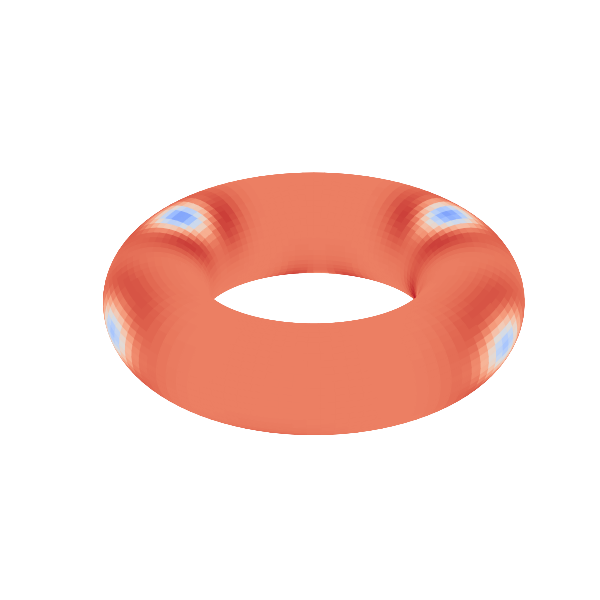

In [444]:
val = fs.reshape((n_p,n_t))
# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

axlim = .8
ax.set_xlim(-axlim,axlim)
ax.set_ylim(-axlim,axlim)
ax.set_zlim(-axlim,axlim)

plt.axis('off')
ax.grid(False)

# Diffusion testing

In [16]:
from laplacebeltrami import *
from rbf import *

In [501]:
n = 2000
nodes, normals = torus_phyllotaxis_points(n)
us, fs = torus_forcing(nodes)

In [502]:
# C = TPM(nodes, normals, rbf_obj=rbf_dict['r^9'], epsilon=None, stencil_size=50, poly_deg=4)
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^4 log(r)'], epsilon=None, stencil_size=31, poly_deg=2)
# C = SOGr(nodes, normals, rbf_obj=rbf_dict['r^9'], stencil_size=100, poly_deg=4)
print(la.norm(C  @ us - fs)/la.norm(fs))

3.3586515751062676


In [487]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^6 log(r)'], epsilon=None, stencil_size=31, poly_deg=3)
print(la.norm(C  @ us - fs)/la.norm(fs))

7.706638127234127


In [498]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^3'], epsilon=None, stencil_size=31, poly_deg=2)
print(la.norm(C  @ us - fs)/la.norm(fs))

0.0710108598058537


In [495]:
np.sum( C@us -fs > 10)

0

In [489]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['gaussian'], epsilon=None, stencil_size=31, poly_deg=3)
print(la.norm(C  @ us - fs)/la.norm(fs))

epsilon set: 0.305283
0.0365503311160541


In [428]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^6 log(r)'], epsilon=None, stencil_size=100, poly_deg=5)
print(la.norm(C  @ us - fs)/la.norm(fs))

13.68181827158336


In [426]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^7'], epsilon=None, stencil_size=100, poly_deg=5)
print(la.norm(C  @ us - fs)/la.norm(fs))

7.882912439746917


In [ ]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^8 log(r)'], epsilon=None, stencil_size=100, poly_deg=5)
print(la.norm(C  @ us - fs)/la.norm(fs))

In [ ]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^9'], epsilon=None, stencil_size=100, poly_deg=5)
print(la.norm(C  @ us - fs)/la.norm(fs))

In [449]:
C = SWM(nodes, normals, rbf_obj=rbf_dict['r^10 log(r)'], epsilon=None, stencil_size=100, poly_deg=5)
print(la.norm(C  @ us - fs)/la.norm(fs))
print(np.max(np.abs(C  @ us - fs)))

0.20930788462954336


In [504]:
C1 = SOGr(nodes, normals, rbf_obj=rbf_dict['r^11'], stencil_size=100, poly_deg=2)
print(la.norm(C1 @ us - fs)/la.norm(fs))

0.04033434716101705


In [430]:
print(la.norm(C  @ us - fs)/la.norm(fs))
print(la.norm(C1 @ us - fs)/la.norm(fs))

0.19407870080209128
0.053423840892839206


<IPython.core.display.Javascript object>


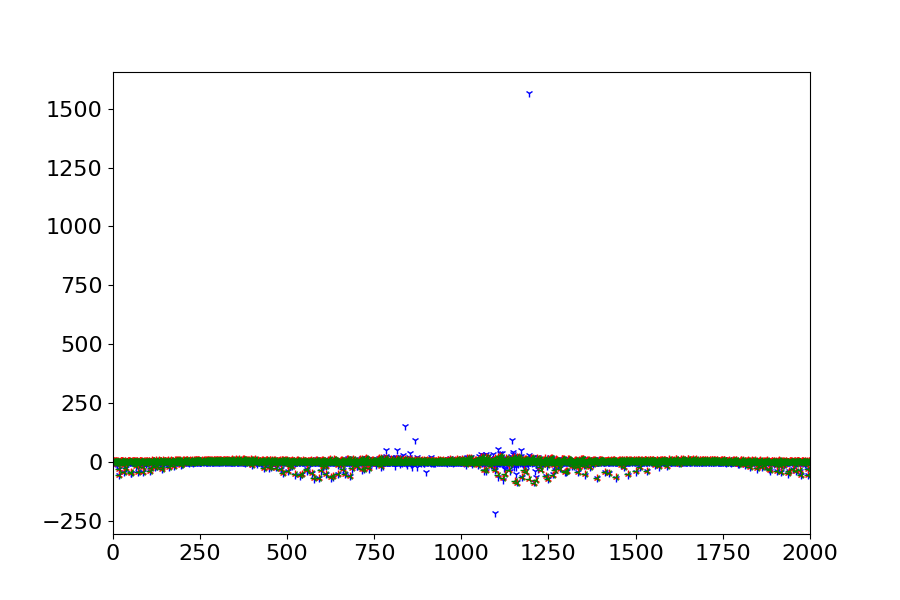

In [505]:
fig = plt.figure(figsize=(9,6))
plt.plot(range(len(us)), C@us, 'b1')
plt.plot(range(len(us)), C1@us, 'r2')
plt.plot(range(len(us)), fs, 'g3')
plt.xlim(0,len(us))
# plt.ylim(-100, 100)
plt.show()

In [508]:
((C @ us - fs)/fs)[1193]

-22.15235226282841

In [507]:
np.argmax(np.abs(C @ us -fs))

1193

<IPython.core.display.Javascript object>


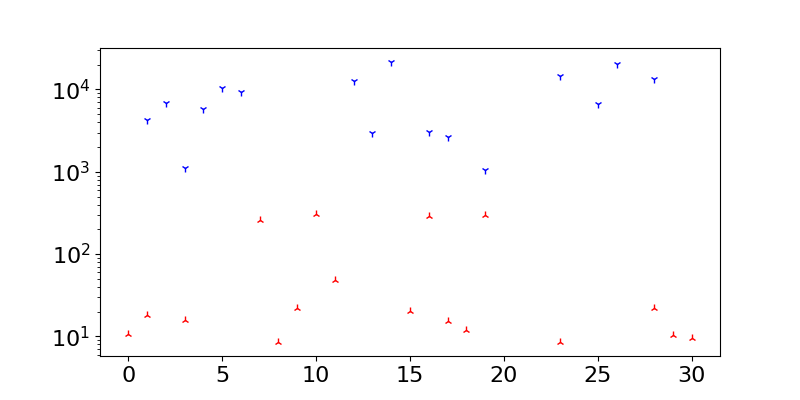

In [509]:
i = np.argmax(np.abs(C @ us -fs))
indices = C[i].toarray() != 0
weights  =  C[i].toarray()[indices]
weights1 = C1[i].toarray()[indices]

fig = plt.figure(figsize=(8,4))
plt.semilogy(range(len(weights)), weights, 'b1')
plt.semilogy(range(len(weights)), weights1, 'r2')
# plt.plot(range(len(us)), fs, 'gx')
# plt.xlim(0,len(us))
# plt.ylim(-1, 1)
plt.show()

<IPython.core.display.Javascript object>


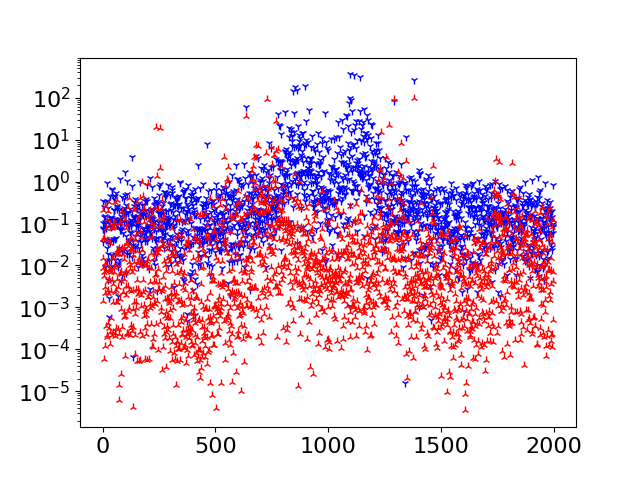

In [510]:
fig = plt.figure()
# plt.semilogy(range(len(us)), np.abs((C@us - fs)/fs), 'b.')
plt.semilogy(range(len(us)), np.abs((C@us - fs)/fs), 'b1')
plt.semilogy(range(len(us)), np.abs((C1@us - fs)/fs), 'r2')
# plt.plot(range(len(us)), C @ us - fs, 'b1')
# plt.plot(range(len(us)), C1@ us - fs, 'r2')
# plt.plot(range(len(us)), fs, 'gx')
# plt.xlim(0,len(us))
# plt.ylim(-1, 1)
plt.show()

## Eigenvalues

In [420]:
eigs = spla.eigs(C, k=min(n,100), which='LR')[0]
# eigs = la.eig(C.todense())[0]
print( np.max(eigs.real), np.max(np.abs(eigs.imag)) )

-7.674755666255043e-14 0.1358835794378375


<IPython.core.display.Javascript object>


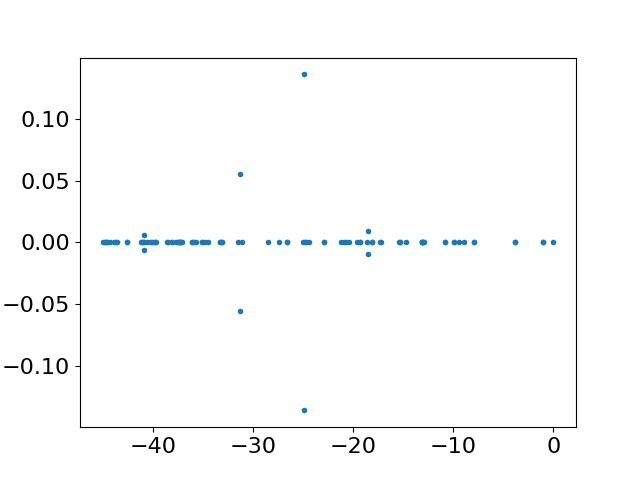

In [421]:
fig = plt.figure()
plt.plot(eigs.real, eigs.imag, '.')
plt.show()

## Plot Surface

In [16]:
def rbf_interp(xs, fs, zs, rbf_obj, k=25, eps=None):
    rbf = rbf_obj['rbf']
    us = np.zeros(len(zs))
    full_dist_mat = dist_outer(xs, zs)
    closest_ids = np.argmin(full_dist_mat, axis=1)
    # in a zoop build surface around each sample point
    for i in range(len(xs)):
        c = xs[i]
        close_to_c_ids = closest_ids == i
        zs_local = zs[close_to_c_ids]
        x_ids = get_closest_indices(i, len(xs), k)
        xs_local = xs[x_ids]
        fs_local = fs[x_ids]
        dist_mat = dist_outer(xs_local,xs_local)
        if rbf_obj['shape'] and eps is None:   
            eps = optimize_eps(rbf, dist_mat)
        A = rbf(dist_mat, eps)
        cs = la.solve(A, fs_local)
        dist_mat = dist_outer(xs_local, zs_local)
        A = rbf(dist_mat, eps)
        us_local = A @ cs
        us[close_to_c_ids] = us_local
    return us

<IPython.core.display.Javascript object>


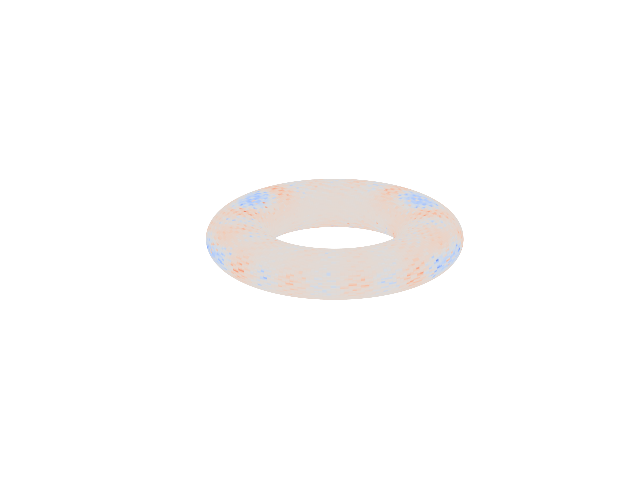

In [17]:
n1, n2 = 200, 100

thetas = np.linspace(0, 2*np.pi, n1)
phis = np.linspace(0, 2*np.pi, n2)

U = np.outer(np.ones(n2), thetas).flatten()
V = np.outer(phis, np.ones(n1)).flatten()

plot_nodes = torus_to_cart(U, V, 1, 1/3)

X = plot_nodes[:, 0].reshape((n2,n1))
Y = plot_nodes[:, 1].reshape((n2,n1))
Z = plot_nodes[:, 2].reshape((n2,n1))

fs_approx = rbf_interp(nodes, C@us, plot_nodes, rbf_dict['multiquadric'], k=50)

val = fs_approx.reshape((n2,n1))

# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = val # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

# plot

fig = plt.figure()
ax = fig.gca(projection='3d')
line = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

ax.set_xlim(-1.4,1.4)
ax.set_ylim(-1.4,1.4)
ax.set_zlim(-1.4,1.4)

plt.axis('off')
ax.grid(False)

## Proj stencil testing

In [266]:
n = 1000
nodes, normals = torus_phyllotaxis_points(n)
us, fs = torus_forcing(nodes)
tree = cKDTree(np.array(nodes))

In [286]:
# my_index = 1829
my_index = 853
k = 100
rbf_obj=rbf_dict['r^6 log(r)']
poly_deg = 5
epsilon = None

poly_type='p'


stencil_size = k
eps = epsilon
i = my_index
n = len(nodes)
rbf = rbf_obj['rbf']
phi1 = rbf_obj['phi1']

projectors = [np.eye(3) - np.outer(node, node) for node in normals]

stencil = tree.query(nodes[i], k)[1]
nn = np.array([nodes[i] for i in stencil])
nn_proj = np.array([projectors[i] for i in stencil])
# center stencil
nn -= nn[0]
# scale stencil
scale = np.max(np.abs(nn))
nn /= scale        

if poly_deg is None:
    P = None
else:
    if poly_type == 'p':
        P, rhs_x, rhs_y, rhs_z = grad_poly(nn, nn_proj, poly_deg)
    elif poly_type == 's':
        P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(poly_deg, nn, nn_proj)
    rhs_x /= scale
    rhs_y /= scale
    rhs_z /= scale

dist_mat = dist_outer(nn,nn)
#print(cond(rbf(dist_mat, 1)))
if epsilon is None and rbf_obj['shape']:
    epsilon = optimize_eps(rbf, dist_mat, P=None, target_cond=10**12)
    print('epsilon set: %g' % epsilon)

A = rbf(dist_mat, epsilon)
rhsAs = np.matmul(nn_proj, grad_rbf_outer(nn, nn, phi1, epsilon).reshape(
        (stencil_size,stencil_size,3,1))).reshape((stencil_size,stencil_size,3))
rhsAs /= scale

weights = np.zeros(k)

if P is None:
    rhs = rhsAs[:,:,0] # only the x coordinates
    weights_grad = la.solve(A, rhs).T
    weights = (weights_grad@weights_grad)[0]

    rhs = rhsAs[:,:,1] # only the y coordinates
    weights_grad = la.solve(A, rhs).T
    weights += (weights_grad@weights_grad)[0]

    rhs = rhsAs[:,:,2] # only the z coordinates
    weights_grad = la.solve(A, rhs).T
    weights += (weights_grad@weights_grad)[0]
else:
    weights_grad = schur_solve(A, P, rhsAs[:,:,0], rhs_x)[0].T
    weights = (weights_grad@weights_grad)[0]
    weights_grad = schur_solve(A, P, rhsAs[:,:,1], rhs_y)[0].T
    weights += (weights_grad@weights_grad)[0]
    weights_grad = schur_solve(A, P, rhsAs[:,:,2], rhs_z)[0].T
    weights += (weights_grad@weights_grad)[0]


In [287]:
my_us = us[stencil]
my_fs = fs[stencil]

In [288]:
(weights @ my_us) - fs[0]

-0.6689877688384542

In [285]:
rhs_x.shape

(56, 100)

In [276]:
rhsAs[:,:,0].shape

(100, 100)

In [277]:
A.shape

(100, 100)

In [278]:
AP = np.block( [[A, P],[P.T, np.zeros((P.shape[1],P.shape[1]))]] )

In [279]:
rhs = np.block([[rhsAs[:,:,0]], [rhs_x]])
w2 = (la.solve(AP, rhs)[:k,:k]).T
weights2 = w2 @ w2

rhs = np.block([[rhsAs[:,:,1]], [rhs_y]])
w2 = (la.solve(AP, rhs)[:k,:k]).T
weights2 += w2 @ w2

rhs = np.block([[rhsAs[:,:,2]], [rhs_z]])
w2 = (la.solve(AP, rhs)[:k,:k]).T
weights2 += w2 @ w2

weights2 = weights2[0]

In [280]:
np.log10(cond(AP))

19.120507050144095

In [281]:
(weights2 @ my_us) - fs[0]

-0.7770494417507414

In [106]:
np.log10(cond(AP))

NameError: name 'AP' is not defined

In [57]:
print(weights @ my_us)
print(fs[my_index])

3.8780028042793004
3.875454464923861


In [58]:
np.log10(cond(A))

12.000001760427136

<IPython.core.display.Javascript object>


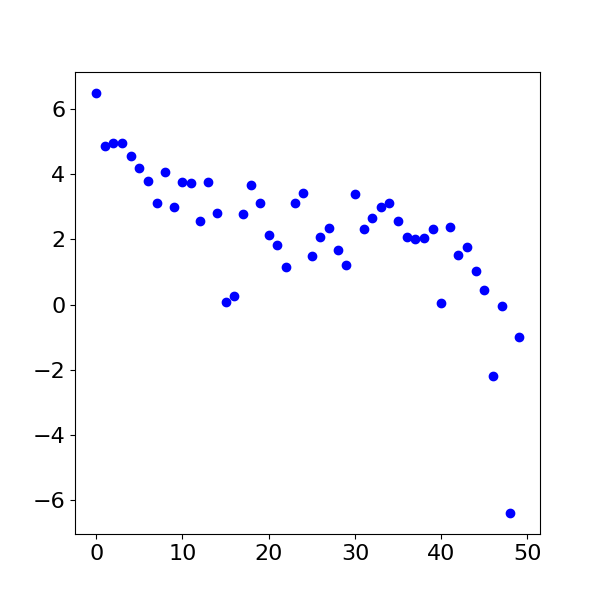

In [187]:
fig = plt.figure(figsize=(6,6))

plt.plot(range(len(weights)), np.log(np.abs(weights)), 'bo')

plt.show()

<IPython.core.display.Javascript object>


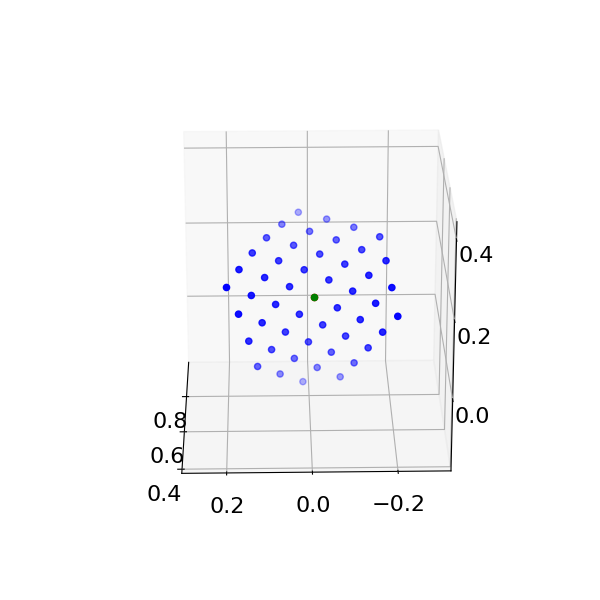

In [189]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

r = .1
ax.scatter(node[0], node[1], node[2], '.', color='r')
ax.scatter(node[0]+r*normal[0], node[1]+r*normal[1], node[2]+r*normal[2], '.', color='g')
ax.scatter(my_nn[1:,0], my_nn[1:,1], my_nn[1:,2], '.', color='b')
# ax.scatter(my_nn[1:,0], my_nn[1:,1], my_nn[1:,2], '.', color='b')
# ax.scatter(normal[0], normal[1], normal[2], '.', color='g')
# ax.scatter(0, 0, 0, '.', color='k')

w = np.max(dist_outer(my_nn, my_nn))*.7
ax.set_xlim(node[0]-w,node[0]+w)
ax.set_ylim(node[1]-w,node[1]+w)
ax.set_zlim(node[2]-w,node[2]+w)

# ax.set_xlim(-1.4,1.4)
# ax.set_ylim(-1.4,1.4)
# ax.set_zlim(-1.4,1.4)
plt.show()

<IPython.core.display.Javascript object>


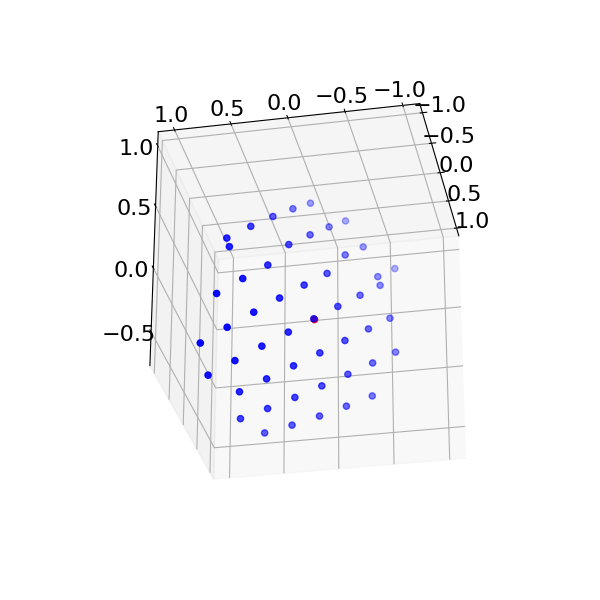

In [190]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

r = .3
# ax.scatter(nn[:,0], nn[:,1], [0]*len(nn[:,0]), '.', color='b')
ax.scatter(nn[:,0], nn[:,1], nn[:,2], '.', color='b')
# ax.scatter(nn[0,0], nn[0,1], 0, '.', color='g')
ax.scatter(0, 0, 0, 'x', color='r')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
# ax.set_zlim(-1.4,1.4)
plt.show()

Surface laplacian of torus is given here: https://arxiv.org/pdf/1404.0812.pdf

In [6]:
from sympy import *

In [7]:
a, b, p, t, p0, t0, s = symbols('a b p t p0 t0 s')

In [8]:
u = exp(-s*(a**2*(1-cos(p-p0)) + b**2*(1-cos(t-t0))))
d = (1+1/3*cos(p))

In [9]:
expr = diff(u, t, t) + 9*d*(diff(  (1+1/3*cos(p))*diff(u,p), p)  )
expr = (expr/u).simplify().expand()

In [10]:
display(expr)

1.0*a**4*s**2*sin(p - p0)**2*cos(p)**2 + 6.0*a**4*s**2*sin(p - p0)**2*cos(p) + 9*a**4*s**2*sin(p - p0)**2 + 1.0*a**2*s*sin(p)*sin(p - p0)*cos(p) + 3.0*a**2*s*sin(p)*sin(p - p0) - 1.0*a**2*s*cos(p)**2*cos(p - p0) - 6.0*a**2*s*cos(p)*cos(p - p0) - 9*a**2*s*cos(p - p0) + b**4*s**2*sin(t - t0)**2 - b**2*s*cos(t - t0)

In [11]:
s = str(expr)
s = s.replace('.0', '')
s = s.replace('sin(p - p0)', 'spk')
s = s.replace('cos(p - p0)', 'cpk')
s = s.replace('sin(t - t0)', 'stk')
s = s.replace('cos(t - t0)', 'ctk')
s = s.replace('cos(p)', 'cp')
s = s.replace('cos(t)', 'ct')
s = s.replace('sin(p)', 'sp')
s = s.replace('sin(t)', 'st')

In [12]:
s

'1*a**4*s**2*spk**2*cp**2 + 6*a**4*s**2*spk**2*cp + 9*a**4*s**2*spk**2 + 1*a**2*s*sp*spk*cp + 3*a**2*s*sp*spk - 1*a**2*s*cp**2*cpk - 6*a**2*s*cp*cpk - 9*a**2*s*cpk + b**4*s**2*stk**2 - b**2*s*ctk'